In [1]:
# Date: 22-5-2017

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# note:
# Because of the 十一黃金周. sth is strange with (2,0,'tot') and others vol from 1 Oct 00:00 to 7 Oct 23:59

df_merged_volume = pd.read_csv("../data/preprocessed_input_interpolate_20min_phase1and2_train.csv")

In [3]:
# change "Date" to datetime object
df_merged_volume['date'] = pd.to_datetime(df_merged_volume['date'])

# construct "time of day"
df_merged_volume['timeofday'] = df_merged_volume.date.apply( lambda d : d.hour+d.minute/60.)

In [7]:
df_merged_volume.head(10)

,"(1, 0, 'cargocar')","(1, 0, 'etc')","(1, 0, 'motorcycle')","(1, 0, 'privatecar')","(1, 0, 'tot')","(1, 0, 'unknowncar')","(1, 1, 'cargocar')","(1, 1, 'etc')","(1, 1, 'motorcycle')","(1, 1, 'privatecar')",...,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,0,1.0,0,0,14.0,14.0,38.0,25.0,89.0,12.0,...,1013.200000,1018.200000,341.000000,3.5,21.100000,68.000000,0.0,1,0,0.000000
1,0,0.0,0,0,13.0,13.0,24.0,11.0,41.0,15.0,...,1013.233333,1018.233333,342.444444,3.4,21.411111,66.888889,0.0,1,0,0.333333
2,0,1.0,0,0,7.0,7.0,10.0,7.0,22.0,5.0,...,1013.266667,1018.266667,343.888889,3.3,21.722222,65.777778,0.0,1,0,0.666667
3,0,2.0,0,0,6.0,6.0,3.0,0.0,3.0,0.0,...,1013.300000,1018.300000,345.333333,3.2,22.033333,64.666667,0.0,1,0,1.000000
4,0,1.0,0,0,5.0,5.0,5.0,0.0,3.0,0.0,...,1013.333333,1018.333333,346.777778,3.1,22.344444,63.555556,0.0,1,0,1.333333
5,0,1.0,0,0,5.0,5.0,3.0,1.0,8.0,0.0,...,1013.366667,1018.366667,348.222222,3.0,22.655556,62.444444,0.0,1,0,1.666667
6,0,0.0,0,0,6.0,6.0,6.0,1.0,2.0,0.0,...,1013.400000,1018.400000,349.666667,2.9,22.966667,61.333333,0.0,1,0,2.000000
7,0,2.0,0,0,9.0,9.0,8.0,1.0,4.0,0.0,...,1013.433333,1018.433333,351.111111,2.8,23.277778,60.222222,0.0,1,0,2.333333
8,0,0.0,0,0,7.0,7.0,4.0,1.0,4.0,0.0,...,1013.466667,1018.466667,352.555556,2.7,23.588889,59.111111,0.0,1,0,2.666667
9,0,0.0,0,0,10.0,10.0,2.0,0.0,0.0,0.0,...,1013.500000,1018.500000,354.000000,2.6,23.900000,58.000000,0.0,1,0,3.000000


In [128]:
df_merged_volume.columns[0:36]

Index(['(1, 0, 'cargocar')', '(1, 0, 'etc')', '(1, 0, 'motorcycle')',
       '(1, 0, 'privatecar')', '(1, 0, 'tot')', '(1, 0, 'unknowncar')',
       '(1, 1, 'cargocar')', '(1, 1, 'etc')', '(1, 1, 'motorcycle')',
       '(1, 1, 'privatecar')', '(1, 1, 'tot')', '(1, 1, 'unknowncar')',
       '(2, 0, 'cargocar')', '(2, 0, 'etc')', '(2, 0, 'motorcycle')',
       '(2, 0, 'privatecar')', '(2, 0, 'tot')', '(2, 0, 'unknowncar')',
       '(3, 0, 'cargocar')', '(3, 0, 'etc')', '(3, 0, 'motorcycle')',
       '(3, 0, 'privatecar')', '(3, 0, 'tot')', '(3, 0, 'unknowncar')',
       '(3, 1, 'cargocar')', '(3, 1, 'etc')', '(3, 1, 'motorcycle')',
       '(3, 1, 'privatecar')', '(3, 1, 'tot')', '(3, 1, 'unknowncar')',
       '('A', 2)', '('A', 3)', '('B', 1)', '('B', 3)', '('C', 1)', '('C', 3)'],
      dtype='object')

In [4]:
# Make the dataset stationary

df_merged_volume_copy = df_merged_volume.copy()

for i in range(1, len(df_merged_volume_copy)):
    df_merged_volume_copy.loc[i, df_merged_volume_copy.columns[0:36]] = df_merged_volume.loc[i, df_merged_volume.columns[0:36]] - df_merged_volume.loc[i-1, df_merged_volume.columns[0:36]]

In [60]:
df_merged_volume_copy

,"(1, 0, 'cargocar')","(1, 0, 'etc')","(1, 0, 'motorcycle')","(1, 0, 'privatecar')","(1, 0, 'tot')","(1, 0, 'unknowncar')","(1, 1, 'cargocar')","(1, 1, 'etc')","(1, 1, 'motorcycle')","(1, 1, 'privatecar')",...,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,0,1.0,0,0,14.0,14.0,38.0,25.0,89.0,12.0,...,1013.200000,1018.200000,341.000000,3.500000,21.100000,68.000000,0.0,1,0,0.000000
1,0,-1.0,0,0,-1.0,-1.0,-14.0,-14.0,-48.0,3.0,...,1013.233333,1018.233333,342.444444,3.400000,21.411111,66.888889,0.0,1,0,0.333333
2,0,1.0,0,0,-6.0,-6.0,-14.0,-4.0,-19.0,-10.0,...,1013.266667,1018.266667,343.888889,3.300000,21.722222,65.777778,0.0,1,0,0.666667
3,0,1.0,0,0,-1.0,-1.0,-7.0,-7.0,-19.0,-5.0,...,1013.300000,1018.300000,345.333333,3.200000,22.033333,64.666667,0.0,1,0,1.000000
4,0,-1.0,0,0,-1.0,-1.0,2.0,0.0,0.0,0.0,...,1013.333333,1018.333333,346.777778,3.100000,22.344444,63.555556,0.0,1,0,1.333333
5,0,0.0,0,0,0.0,0.0,-2.0,1.0,5.0,0.0,...,1013.366667,1018.366667,348.222222,3.000000,22.655556,62.444444,0.0,1,0,1.666667
6,0,-1.0,0,0,1.0,1.0,3.0,0.0,-6.0,0.0,...,1013.400000,1018.400000,349.666667,2.900000,22.966667,61.333333,0.0,1,0,2.000000
7,0,2.0,0,0,3.0,3.0,2.0,0.0,2.0,0.0,...,1013.433333,1018.433333,351.111111,2.800000,23.277778,60.222222,0.0,1,0,2.333333
8,0,-2.0,0,0,-2.0,-2.0,-4.0,0.0,0.0,0.0,...,1013.466667,1018.466667,352.555556,2.700000,23.588889,59.111111,0.0,1,0,2.666667
9,0,0.0,0,0,3.0,3.0,-2.0,-1.0,-4.0,0.0,...,1013.500000,1018.500000,354.000000,2.600000,23.900000,58.000000,0.0,1,0,3.000000


In [5]:
for idx, i in enumerate(df_merged_volume.columns):
    print(idx, i)

0 (1, 0, 'cargocar')
1 (1, 0, 'etc')
2 (1, 0, 'motorcycle')
3 (1, 0, 'privatecar')
4 (1, 0, 'tot')
5 (1, 0, 'unknowncar')
6 (1, 1, 'cargocar')
7 (1, 1, 'etc')
8 (1, 1, 'motorcycle')
9 (1, 1, 'privatecar')
10 (1, 1, 'tot')
11 (1, 1, 'unknowncar')
12 (2, 0, 'cargocar')
13 (2, 0, 'etc')
14 (2, 0, 'motorcycle')
15 (2, 0, 'privatecar')
16 (2, 0, 'tot')
17 (2, 0, 'unknowncar')
18 (3, 0, 'cargocar')
19 (3, 0, 'etc')
20 (3, 0, 'motorcycle')
21 (3, 0, 'privatecar')
22 (3, 0, 'tot')
23 (3, 0, 'unknowncar')
24 (3, 1, 'cargocar')
25 (3, 1, 'etc')
26 (3, 1, 'motorcycle')
27 (3, 1, 'privatecar')
28 (3, 1, 'tot')
29 (3, 1, 'unknowncar')
30 ('A', 2)
31 ('A', 3)
32 ('B', 1)
33 ('B', 3)
34 ('C', 1)
35 ('C', 3)
36 date
37 hour
38 pressure
39 sea_pressure
40 wind_direction
41 wind_speed
42 temperature
43 rel_humidity
44 precipitation
45 dayofweek
46 is_holiday
47 timeofday


In [11]:
''' OLD Function for converting it as stationary data'''

# # create a differenced series for Volumn and traffic time [modified from http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/]
# def difference(dataset, interval=1):
#     diff_array = np.ndarray(np.shape(dataset))
#     for i in range(interval, len(dataset)):
#         diff_array[i][0:2] = dataset[i][0:2] - dataset[i - interval][0:2]  # only select index 0 & 1
#     return diff_array[1:]  # eliminate the first row (all zeros)

# # invert differenced value
# def inverse_difference(history, y_hat, interval=1):
#     return y_hat + history[-interval]

' OLD Function for converting it as stationary data'

In [6]:
# select the time for training: 6:20-10:00 (5 + 6 timestamp) and 15:20-19:00 (5 + 6 timestamp)
sel_rows = df_merged_volume_copy
# sel_rows = df_merged_volume_copy[ ((df_merged_volume_copy.timeofday>= 6.3) & (df_merged_volume_copy.timeofday<10)) |
#                             ((df_merged_volume_copy.timeofday>=15.3) & (df_merged_volume_copy.timeofday<19))]

In [7]:
# select using columns

using_cols = [
#                 "(1, 0, 'cargocar')",
#                 "(1, 0, 'etc')",
#                 "(1, 0, 'motorcycle')",
#                 "(1, 0, 'privatecar')",
#                 "(1, 0, 'tot')",
#                 "(1, 0, 'unknowncar')",
#                 "(1, 1, 'cargocar')",
#                 "(1, 1, 'etc')",
#                 "(1, 1, 'motorcycle')",
#                 "(1, 1, 'privatecar')",
#                 "(1, 1, 'tot')",
#                 "(1, 1, 'unknowncar')",
#                 "(2, 0, 'cargocar')",
                "(2, 0, 'etc')",
#                 "(2, 0, 'motorcycle')",
#                 "(2, 0, 'privatecar')",
                "(2, 0, 'tot')",
#                 "(2, 0, 'unknowncar')",
#                 "(3, 0, 'cargocar')",
#                 "(3, 0, 'etc')",
#                 "(3, 0, 'motorcycle')",
#                 "(3, 0, 'privatecar')",
#                 "(3, 0, 'tot')",
#                 "(3, 0, 'unknowncar')",
#                 "(3, 1, 'cargocar')",
#                 "(3, 1, 'etc')",
#                 "(3, 1, 'motorcycle')",
#                 "(3, 1, 'privatecar')",
#                 "(3, 1, 'tot')",
#                 "(3, 1, 'unknowncar')",
                "('A', 2)",
#                 "('A', 3)",
#                 "('B', 1)",
#                 "('B', 3)",
#                 "('C', 1)",
#                 "('C', 3)",
                'date',
                'hour',
                'pressure',
                'sea_pressure',
                'wind_direction',
                'wind_speed',
                'temperature',
                'rel_humidity',
                'precipitation',
                'dayofweek',
                'is_holiday',
                'timeofday'
              ]

sel_rows = sel_rows[using_cols]

In [9]:
sel_rows = sel_rows[1:]
sel_rows

,"(2, 0, 'etc')","(2, 0, 'tot')","('A', 2)",date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
1,2.0,2.0,-8.512500,2016-09-20 00:20:00,0,1013.233333,1018.233333,342.444444,3.400000,21.411111,66.888889,0.0,1,0,0.333333
2,0.0,0.0,-8.512500,2016-09-20 00:40:00,0,1013.266667,1018.266667,343.888889,3.300000,21.722222,65.777778,0.0,1,0,0.666667
3,-2.0,-2.0,-1.710000,2016-09-20 01:00:00,1,1013.300000,1018.300000,345.333333,3.200000,22.033333,64.666667,0.0,1,0,1.000000
4,1.0,1.0,-1.710000,2016-09-20 01:20:00,1,1013.333333,1018.333333,346.777778,3.100000,22.344444,63.555556,0.0,1,0,1.333333
5,-1.0,-1.0,7.940000,2016-09-20 01:40:00,1,1013.366667,1018.366667,348.222222,3.000000,22.655556,62.444444,0.0,1,0,1.666667
6,0.0,0.0,8.395000,2016-09-20 02:00:00,2,1013.400000,1018.400000,349.666667,2.900000,22.966667,61.333333,0.0,1,0,2.000000
7,0.0,0.0,8.395000,2016-09-20 02:20:00,2,1013.433333,1018.433333,351.111111,2.800000,23.277778,60.222222,0.0,1,0,2.333333
8,0.0,0.0,-15.767500,2016-09-20 02:40:00,2,1013.466667,1018.466667,352.555556,2.700000,23.588889,59.111111,0.0,1,0,2.666667
9,0.0,0.0,-15.767500,2016-09-20 03:00:00,3,1013.500000,1018.500000,354.000000,2.600000,23.900000,58.000000,0.0,1,0,3.000000
10,0.0,0.0,1.905000,2016-09-20 03:20:00,3,1013.355556,1018.355556,315.444444,2.822222,24.233333,56.333333,0.0,1,0,3.333333


In [10]:
# split to train and test set
train_rows = sel_rows[: -22*]
test_rows = sel_rows[-22*2:] # reserve 2 days for test

# del date column for eliminate datetime
del train_rows['date']
del test_rows['date']

# get numpy array from panda dataframe
train_arr = train_rows.values
test_arr = test_rows.values

# np.shape(train_arr)
# Out:
# (726, 17)

In [11]:
#scale feature array to range -1 to 1

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_arr)
train_scaled_arr = scaler.transform(train_arr)

test_scaled_arr = scaler.transform(test_arr)

In [183]:
test_scaled_arr[-5:]

array([[-0.07407407,  0.02290076, -0.00362976,  0.83333333,  0.09170719,
         0.09125637,  0.98183371, -0.09828989, -0.41798835,  0.58013324,
        -1.        , -1.        ,  0.        ,  0.78378378],
       [ 0.37037037,  0.2519084 ,  0.0028705 ,  0.83333333,  0.09076042,
         0.09032258,  0.98220827, -0.0977918 , -0.41778631,  0.57985421,
        -1.        , -1.        ,  0.        ,  0.83783784],
       [-0.40740741,  0.11450382,  0.19085073,  1.        ,  0.08981366,
         0.08938879,  0.98258283, -0.09729371, -0.41758427,  0.57957518,
        -1.        , -1.        ,  0.        ,  0.89189189],
       [-0.18518519,  0.11450382,  0.08357685,  1.        ,  0.08886689,
         0.08845501,  0.98295739, -0.09679562, -0.41738223,  0.57929615,
        -1.        , -1.        ,  0.        ,  0.94594595],
       [ 0.03703704,  0.11450382,  0.12118653,  1.        ,  0.08792013,
         0.08752122,  0.98333196, -0.09629753, -0.41718019,  0.57901713,
        -1.        , -1.  

In [12]:
# sample subsequence from the time series
train_seqs = []
nSegments = len(train_scaled_arr)//11 # each segment holds 4hr data (12 datapoints, 20min each)
for segment in range(nSegments):
    for t in range(6):
        startIdx = segment*11 + t
        train_seqs.append(train_scaled_arr[startIdx: startIdx+6])  # append 6 timestamps each time (5 timestamps for x, 1 timestamp for y)
train_seqs = np.stack(train_seqs)

test_seqs = []
nSegments = len(test_scaled_arr)//11 # each segment holds 4hr data (12 datapoints, 20min each)
for segment in range(nSegments):
    for t in range(6):
        startIdx = segment*11 + t
        test_seqs.append(test_scaled_arr[startIdx: startIdx+6])
test_seqs = np.stack(test_seqs)

In [ ]:
train_seqs[:,:,0:6].shape  # checking for Index 0 to index 5 (6 values) for output

In [13]:
#keras
#https://keras.io/getting-started/sequential-model-guide/#examples
input_dim = len(using_cols) - 1  # The minus 1 is for deleted "date" feature
output_dim = 3  # 2 vloumns and 1 traffic time output only
timesteps = 5 # use 5 timesteps to predict the 6th

x_train, y_train = train_seqs[:, 0:-1], train_seqs[:, -1,0:3]  # 0:3 is for output dimensions
x_test , y_test  =  test_seqs[:, 0:-1],  test_seqs[:, -1,0:3]

In [188]:
y_train.shape

(396, 3)

In [15]:
num_epochs = 200
loss_fuc = 'mean_squared_error'

# construct the callback
filepath="best_epoch_all_time.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(output_dim))
model.compile(loss=loss_fuc, optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 128)            73216     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 205,187
Trainable params: 205,187
Non-trainable params: 0
_________________________________________________________________
Train on 1350 samples, validate on 24 samples
Epoch 1/200
1350/1350 [==============================] - 2s - loss: 0.0233 - val_loss: 0.0178
Epoch 2/200
1350/1350 [==============================] - 1s - loss: 0.0224 - val_loss: 0.0175
Epoch 3/200
1350/1350 [==============================] - 1s - loss: 0.0223 - val_loss: 0.0177
Epoch 4/200
1350/1350 [==============================] - 1s - loss: 0.02

1350/1350 [==============================] - 1s - loss: 0.0167 - val_loss: 0.0126
Epoch 33/200
1350/1350 [==============================] - 1s - loss: 0.0160 - val_loss: 0.0127
Epoch 34/200
1350/1350 [==============================] - 1s - loss: 0.0158 - val_loss: 0.0130
Epoch 35/200
1350/1350 [==============================] - 1s - loss: 0.0164 - val_loss: 0.0131
Epoch 36/200
1350/1350 [==============================] - 1s - loss: 0.0157 - val_loss: 0.0131
Epoch 37/200
1350/1350 [==============================] - 1s - loss: 0.0152 - val_loss: 0.0133
Epoch 38/200
1350/1350 [==============================] - 1s - loss: 0.0153 - val_loss: 0.0126
Epoch 39/200
1350/1350 [==============================] - 1s - loss: 0.0156 - val_loss: 0.0128
Epoch 40/200
1350/1350 [==============================] - 1s - loss: 0.0151 - val_loss: 0.0136
Epoch 41/200
1350/1350 [==============================] - 1s - loss: 0.0153 - val_loss: 0.0136
Epoch 42/200
1350/1350 [==============================] - 1s - 

1350/1350 [==============================] - 1s - loss: 0.0109 - val_loss: 0.0139
Epoch 73/200
1350/1350 [==============================] - 1s - loss: 0.0111 - val_loss: 0.0148
Epoch 74/200
1350/1350 [==============================] - 1s - loss: 0.0104 - val_loss: 0.0140
Epoch 75/200
1350/1350 [==============================] - 1s - loss: 0.0104 - val_loss: 0.0147
Epoch 76/200
1350/1350 [==============================] - 1s - loss: 0.0104 - val_loss: 0.0146
Epoch 77/200
1350/1350 [==============================] - 1s - loss: 0.0101 - val_loss: 0.0141
Epoch 78/200
1350/1350 [==============================] - 1s - loss: 0.0096 - val_loss: 0.0141
Epoch 79/200
1350/1350 [==============================] - 1s - loss: 0.0109 - val_loss: 0.0152
Epoch 80/200
1350/1350 [==============================] - 1s - loss: 0.0117 - val_loss: 0.0141
Epoch 81/200
1350/1350 [==============================] - 1s - loss: 0.0103 - val_loss: 0.0151
Epoch 82/200
1350/1350 [==============================] - 1s - 

1350/1350 [==============================] - 1s - loss: 0.0048 - val_loss: 0.0165
Epoch 114/200
1350/1350 [==============================] - 1s - loss: 0.0044 - val_loss: 0.0157
Epoch 115/200
1350/1350 [==============================] - 1s - loss: 0.0045 - val_loss: 0.0175
Epoch 116/200
1350/1350 [==============================] - 1s - loss: 0.0044 - val_loss: 0.0157
Epoch 117/200
1350/1350 [==============================] - 1s - loss: 0.0040 - val_loss: 0.0165
Epoch 118/200
1350/1350 [==============================] - 1s - loss: 0.0040 - val_loss: 0.0164
Epoch 119/200
1350/1350 [==============================] - 1s - loss: 0.0038 - val_loss: 0.0160
Epoch 120/200
1350/1350 [==============================] - 1s - loss: 0.0040 - val_loss: 0.0164
Epoch 121/200
1350/1350 [==============================] - 1s - loss: 0.0038 - val_loss: 0.0161
Epoch 122/200
1350/1350 [==============================] - 1s - loss: 0.0039 - val_loss: 0.0172
Epoch 123/200
1350/1350 [=============================

1350/1350 [==============================] - 1s - loss: 0.0025 - val_loss: 0.0190
Epoch 155/200
1350/1350 [==============================] - 1s - loss: 0.0023 - val_loss: 0.0173
Epoch 156/200
1350/1350 [==============================] - 1s - loss: 0.0024 - val_loss: 0.0175
Epoch 157/200
1350/1350 [==============================] - 1s - loss: 0.0021 - val_loss: 0.0172
Epoch 158/200
1350/1350 [==============================] - 1s - loss: 0.0018 - val_loss: 0.0178
Epoch 159/200
1350/1350 [==============================] - 1s - loss: 0.0018 - val_loss: 0.0179
Epoch 160/200
1350/1350 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0177
Epoch 161/200
1350/1350 [==============================] - 1s - loss: 0.0019 - val_loss: 0.0173
Epoch 162/200
1350/1350 [==============================] - 1s - loss: 0.0017 - val_loss: 0.0184
Epoch 163/200
1350/1350 [==============================] - 1s - loss: 0.0016 - val_loss: 0.0175
Epoch 164/200
1350/1350 [=============================

1350/1350 [==============================] - 1s - loss: 0.0010 - val_loss: 0.0171
Epoch 195/200
1350/1350 [==============================] - 1s - loss: 0.0012 - val_loss: 0.0183
Epoch 196/200
1350/1350 [==============================] - 1s - loss: 0.0010 - val_loss: 0.0169
Epoch 197/200
1350/1350 [==============================] - 1s - loss: 0.0010 - val_loss: 0.0173
Epoch 198/200
1350/1350 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0164
Epoch 199/200
1350/1350 [==============================] - 1s - loss: 0.0011 - val_loss: 0.0179
Epoch 200/200
1350/1350 [==============================] - 1s - loss: 0.0010 - val_loss: 0.0176


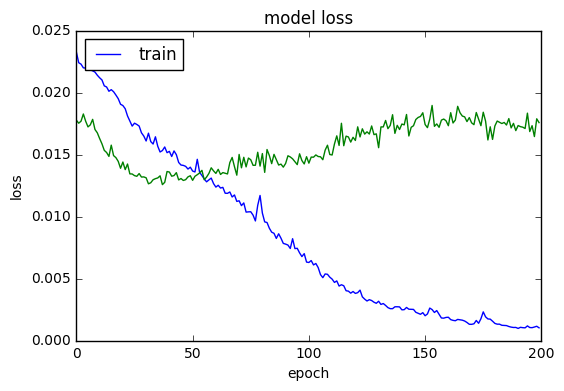

In [16]:
## Start Training
model.summary()
history_w_model = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=num_epochs, batch_size=64, validation_data=(x_test,y_test))

plt.plot(history_w_model.history['loss'], label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history_w_model.history['val_loss'], label='Val_loss')
plt.show()

In [21]:
# load weights into the model
model.load_weights("best_epoch.hdf5")
print("Loaded model from disk")

model.compile(loss='mean_squared_error', optimizer='adam')

Loaded model from disk


In [317]:
''' === Prediction ===
Procedure:
1. Load CSV
2. to_datetime
3. create timeofday column
4. select the time for training: 6:00-8:00 (6 timestamps) and 15:00-17:00 (6 timestamps)
5. change it to stationary
6. Use using_cols to select the features
7. del 'date'
8. change to np array
9. MinMaxScaler
10. make the sequences tensor as input
11. make a forloop for prediction

'''
# 1. Load CSV - Vol + Route + Weather (Only Weather is 24-hour data)
df_pred = pd.read_csv('../data/preprocessed_input_interpolate_20min_phase2_test.csv')

# 2. to_datetime
df_pred['date'] = pd.to_datetime(df_pred['date'])

# 3. create timeofday column
df_pred['timeofday'] = df_pred.date.apply( lambda d : d.hour+d.minute/60.)

# 4. select the time for training

df_pred_sel_time = df_pred[ ((df_merged_volume_copy.timeofday>= 6) & (df_merged_volume_copy.timeofday<8)) |
                            ((df_merged_volume_copy.timeofday>=15) & (df_merged_volume_copy.timeofday<17))]

df_feedin_weather_sel_time = df_pred[ ((df_merged_volume_copy.timeofday>= 8) & (df_merged_volume_copy.timeofday<10)) |
                            ((df_merged_volume_copy.timeofday>=17) & (df_merged_volume_copy.timeofday<19))]

# 5. change it to stationary
df_pred_sel_time = df_pred_sel_time.reset_index(drop=True)

df_pred_sel_time_copy = df_pred_sel_time.copy()



for i in range(len(df_pred_sel_time_copy)//6):  # make the loop for 14 time slots (2 different time slot x 7days)
    for t in range(5):  #  Do the "difference" 5 times every loop
        start_idx = i*6 + t + 1  # Add 1 is for starting it from index 1 in every 6-space time slot
        df_pred_sel_time_copy.loc[start_idx, df_pred_sel_time_copy.columns[0:36]] = df_pred_sel_time.loc[start_idx, df_pred_sel_time.columns[0:36]] - df_pred_sel_time.loc[start_idx-1, df_pred_sel_time.columns[0:36]]

# 6. Use using_cols to select the features
sel_rows_pred = df_pred_sel_time_copy[ using_cols ]

sel_rows_feedin_weather = df_feedin_weather_sel_time[using_cols[3:]]

# 7. del 'date'
del sel_rows_pred['date']
del sel_rows_feedin_weather['date']

# 8. change to np array
pred_arr = sel_rows_pred.values

feedin_weather_arr = sel_rows_feedin_weather.values

# 9. MinMaxScaler
pred_arr_scaled = scaler.transform(pred_arr)

# add some dummy cells in front of the weather_array for transform
temp_arr = np.zeros((84,3))
feedin_weather_arr = np.concatenate([temp_arr, feedin_weather_arr], axis=1)

feedin_weather_arr_scaled = scaler.transform(feedin_weather_arr)

# Now pred_arr_scaled is (84 x 17)

/Users/Kin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/Kin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [318]:
# 10. make the sequences tensor as input
# Put into the model to get the prediction

ans_arr = []  # For holding the output answer
    
for i in range(len(pred_arr_scaled)//6):  # make the loop for 14 time slots (2 different time slot x 7days)
    # creating pre_seq
    pred_seq = []
    for t in range(5):  #  Do the "difference" 5 times every loop
        k = i*6 + t + 1  # Add 1 is for starting it from index 1 in every 6-space time slot, to ignore the first index which is non-stationary
        pred_seq.append(pred_arr_scaled[k])  # creating a sequence for a time slot
    
    # creating feedin_weather_seq
    feedin_weather_seq = []
    for t in range(6):  #  Do 6 times every loop
        k = i*6 + t  #
        feedin_weather_seq.append(feedin_weather_arr_scaled[k])


    pred_seq = np.stack(pred_seq)  # change back to the numpy array (2D)
    pred_seq = pred_seq.reshape(1, pred_seq.shape[0], pred_seq.shape[1])  # change to numpy 3D as input

    feedin_weather_seq = np.stack(feedin_weather_seq)  # change back to the numpy array (2D)
    feedin_weather_seq = feedin_weather_seq.reshape(1, feedin_weather_seq.shape[0], feedin_weather_seq.shape[1])  # change to numpy 3D as input

    for q in range(6):
        # predict next timestamp
        output_pred = model.predict(pred_seq)  # get one prediction output (size (1 x 3))
        ans_arr.append(output_pred)

        # update the input seq
        for j in range(1,5):
            pred_seq[0][j-1] = pred_seq[0][j]
        pred_seq[0][4] = feedin_weather_seq[0][q]
        pred_seq[0][4][0:3] = output_pred[0]

In [319]:
ans_arr

[array([[-0.03416985,  0.64532489,  0.324485  ]], dtype=float32),
 array([[ 0.01828507,  0.09214953,  0.10641111]], dtype=float32),
 array([[ 0.02829109,  0.24142185,  0.11610636]], dtype=float32),
 array([[-0.43514609, -0.13018453, -0.06435183]], dtype=float32),
 array([[-0.28384611, -0.01437771,  0.11283149]], dtype=float32),
 array([[ 0.09849536,  0.31616166,  0.07602754]], dtype=float32),
 array([[ 0.23560739,  0.26252785,  0.06468093]], dtype=float32),
 array([[ 0.030499  ,  0.15343568,  0.16943   ]], dtype=float32),
 array([[-0.12590998,  0.07665193, -0.03927835]], dtype=float32),
 array([[ 0.08959169,  0.17510627,  0.10864791]], dtype=float32),
 array([[ 0.04797691,  0.11991245,  0.06576282]], dtype=float32),
 array([[ 0.007465  ,  0.10483809,  0.11402231]], dtype=float32),
 array([[ 0.02783623,  0.67880082,  0.34572574]], dtype=float32),
 array([[-0.48091024, -0.18603581,  0.24059035]], dtype=float32),
 array([[-0.02453759,  0.30475402,  0.1661666 ]], dtype=float32),
 array([[ 

In [ ]:
''' Problems, in row 48 (= Day 5)'''

In [320]:
for i in range(len(ans_arr)):
    print(i, backward_scaler(ans_arr[i]))

0 [  0.07741418  26.76878002  30.09120459]
1 [ 1.49369698 -9.46420557 -0.57769562]
2 [ 1.76385947  0.31313108  0.78579892]
3 [-10.74894452 -24.02708679 -24.59300353]
4 [ -6.66384497 -16.44174021   0.32523598]
5 [ 3.65937463  5.20858888 -4.85070024]
6 [ 7.36139941  1.69557439 -6.44643461]
7 [ 1.8234731  -5.44996314  8.28498848]
8 [ -2.39956957 -10.47929853 -21.06678563]
9 [ 3.41897561 -4.03053918 -0.26312267]
10 [ 2.2953765  -7.64573482 -6.29428347]
11 [ 1.20155513 -8.63310523  0.49270827]
12 [  1.7515783   28.9614538   33.07840388]
13 [-11.98457652 -27.68534568  18.29264948]
14 [ 0.33748519  4.46138823  7.82603919]
15 [  5.03784814  20.79391548 -13.21791528]
16 [ -3.27902487 -10.88129438  -4.90676254]
17 [-11.43291909 -10.64171317   7.03151034]
18 [ -5.20885065 -17.64806157 -20.18587072]
19 [  5.78476664  16.63584927  32.09675621]
20 [ -1.53132403 -13.50918842 -18.00969289]
21 [ -3.52981248  -3.31621791  16.96057263]
22 [ -2.79900816 -11.8897677  -15.41184441]
23 [ -3.66278622 -11.0136

/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data h

In [314]:
def backward_scaler(nn_output):
    tmp = np.zeros(14)
    tmp[0:3] = nn_output
    tmp = scaler.inverse_transform(tmp)
    return tmp[0:3]

In [296]:
def decode(last_timestamp_values, nn_output):
    tmp = np.zeros(14)
    tmp[0:3] = nn_output
    tmp = scaler.inverse_transform(tmp)
    return last_timestamp_values + tmp[0:3]

In [281]:
# create the non-stationary 6:40 and 16:40 for decoding
df_non_station_sel_time = df_pred[ ((df_merged_volume_copy.timeofday>= 7.5) & (df_merged_volume_copy.timeofday<8)) |
                            ((df_merged_volume_copy.timeofday>=16.5) & (df_merged_volume_copy.timeofday<17))]

/Users/Kin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [312]:
df_non_station_sel_time[using_cols[0:3]].iloc[8]

(2, 0, 'etc')    19.000000
(2, 0, 'tot')    61.000000
('A', 2)         53.751765
Name: 311, dtype: float64

In [297]:
tmp = df_non_station_sel_time[using_cols[0:3]].values
allAns = []
for i in range(len(tmp)):
    seed = tmp[i]  # non-stationary for reconstructing a sequence
    segmentAns = []
    for timestep in range(6):
        seed = decode(seed, ans_arr[i*6+timestep])
        segmentAns.append(seed)
    allAns.append(segmentAns)

/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data h

In [307]:
allAns = np.array(allAns)
allAns

array([[[  38.07741418,  119.76878002,   90.68995459],
        [  39.57111116,  110.30457446,   90.11225897],
        [  41.33497062,  110.61770554,   90.89805789],
        [  30.5860261 ,   86.59061874,   66.30505436],
        [  23.92218113,   70.14887853,   66.63029035],
        [  27.58155576,   75.35746741,   61.77959011]],

       [[  24.36139941,   70.69557439,   62.79134317],
        [  26.18487252,   65.24561125,   71.07633165],
        [  23.78530294,   54.76631272,   50.00954602],
        [  27.20427856,   50.73577354,   49.74642335],
        [  29.49965506,   43.09003872,   43.45213988],
        [  30.70121019,   34.4569335 ,   43.94484815]],

       [[  43.7515783 ,  127.9614538 ,   79.62173721],
        [  31.76700178,  100.27610812,   97.91438669],
        [  32.10448696,  104.73749635,  105.74042587],
        [  37.14233511,  125.53141183,   92.52251059],
        [  33.86331024,  114.65011744,   87.61574805],
        [  22.43039116,  104.00840427,   94.64725839]],

    